In [5]:
%load_ext autoreload
%autoreload 2

In [4]:
from lib import DihedralAdherence
from lib import PDBMineQuery, MultiWindowQuery
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
from tabulate import tabulate
from collections import defaultdict
from dotenv import load_dotenv
import torch
from torch import nn
import torch.nn.functional as F
from scipy.stats import gaussian_kde
from sklearn.model_selection import train_test_split
import pickle
from torch.utils.data import TensorDataset, DataLoader, Dataset, ConcatDataset
from torch.utils.tensorboard import SummaryWriter
from lib.constants import AMINO_ACID_MAP, AMINO_ACID_MAP_INV
from lib.across_window_utils import (
    get_phi_psi_dist_window, get_afs_window, get_xrays_window, get_cluster_medoid, find_clusters,
    precompute_dists, filter_precomputed_dists, 
)
from collections import defaultdict
PDBMINE_URL = os.getenv("PDBMINE_URL")
PROJECT_DIR = 'ml_data'

In [3]:
from matplotlib.patches import ConnectionPatch

def plot(q, seq_ctxt, xrays, afs, clusters, phi_psi_dist, precomputed_dists):
    n_cluster_plot = 10
    n_clusters = len(np.unique(clusters))
    xrays = xrays.reshape(2, -1)
    afs = afs.reshape(2, -1)
    print(pd.Series(clusters).value_counts())

    cluster_points = phi_psi_dist.groupby(clusters).count().sort_values('phi_0', ascending=False).index.values
    clusters_plot = cluster_points[:n_cluster_plot]
    medoids = []
    for cluster in cluster_points:
        medoid = get_cluster_medoid(phi_psi_dist, precomputed_dists, clusters, cluster)
        medoids.append(medoid)
    medoids = np.array(medoids)

    colors = sns.color_palette('Dark2', n_clusters)
    fig, axes = plt.subplots(len(clusters_plot), q.winsize, figsize=(16, min(n_cluster_plot, len(clusters_plot))*4), sharey=True, sharex=True)
    if axes.ndim == 1:
        axes = axes.reshape(1, -1)
    for i,axrow in enumerate(axes):
        for j, ax in enumerate(axrow):
            cluster_dist = phi_psi_dist[clusters == clusters_plot[i]]

            sns.scatterplot(data=phi_psi_dist[clusters != clusters_plot[i]], x=f'phi_{j}', y=f'psi_{j}', ax=ax, label='Other Clusters', color='tab:blue', alpha=0.5)
            sns.scatterplot(data=cluster_dist, x=f'phi_{j}', y=f'psi_{j}', ax=ax, label=f'Cluster {clusters_plot[i]}', color=colors[i])
            ax.scatter(xrays[0,j], xrays[1,j], color='tab:red', marker='X', label='X-ray', zorder=1000)
            ax.scatter(afs[0,j], afs[1,j], color='tab:orange', marker='X', label='AF', zorder=1000)
            # ax.scatter(pred[0,j], pred[1,j], color='tab:orange', marker='X', label=pred_id, zorder=1000)
            ax.scatter(medoids[i].reshape(2,-1)[0,j], medoids[i].reshape(2,-1)[1,j], color='black', marker='X', label='Cluster Centroid', zorder=1000)

            def add_conn(xyA, xyB, color, lw, **kwargs):
                con = ConnectionPatch(
                    xyA=xyA, 
                    xyB=xyB, 
                    coordsA="data", coordsB="data", 
                    axesA=axrow[j], axesB=axrow[j+1], 
                    color=color, lw=lw, linestyle='--', alpha=0.5, **kwargs
                )
                fig.add_artist(con)
            if j < q.winsize - 1:
                # TODO draw lines for 50 points closest to centroid
                for k, row in cluster_dist.sample(min(cluster_dist.shape[0], 50)).iterrows():
                    add_conn((row[f'phi_{j}'], row[f'psi_{j}']), (row[f'phi_{j+1}'], row[f'psi_{j+1}']), colors[i], 1)
                add_conn((xrays[0,j], xrays[1,j]), (xrays[0,j+1], xrays[1,j+1]), 'tab:red', 5, zorder=100)
                add_conn((afs[0,j], afs[1,j]), (afs[0,j+1], afs[1,j+1]), 'tab:orange', 5, zorder=100)
                # add_conn((pred[0,j], pred[1,j]), (pred[0,j+1], pred[1,j+1]), 'tab:orange', 5, zorder=100)
                add_conn((medoids[i].reshape(2,-1)[0,j], medoids[i].reshape(2,-1)[1,j]), (medoids[i].reshape(2,-1)[0,j+1], medoids[i].reshape(2,-1)[1,j+1]), 'black', 5, zorder=100)

            ax.set_xlim(-180, 180)
            ax.set_ylim(-180, 180)
            ax.set_xlabel('')
            if j == q.winsize - 1:
                ax.legend()
            else:
                ax.legend().remove()
            if j == 0:
                ax.set_ylabel(f'Cluster {clusters_plot[i]} [{cluster_dist.shape[0]}]')
    fig.supxlabel('Phi')
    fig.supylabel('Psi')
    # fig.suptitle(
    #     # f'Clustered Phi/Psi Distributions for {seq_ctxt} in protein {da.casp_protein_id}: N={n_points} Silhouette Score: {sil_score:.2f}, X-ray Score [Cluster {nearest_cluster}]: {xray_sil:.2f}, Prediction Score [Cluster {nearest_cluster_pred}]: {pred_sil:.2f}', 
    #     f'Clustered Phi/Psi Distributions for {seq_ctxt} in protein {da.casp_protein_id}: N={n_points} ({n_unassigned} unassigned) Silhouette Score: {sil_score:.2f}, X-ray Score [Cluster {nearest_cluster}]: {xray_maha:.2f}', 
    #     y=1.01
    # )
    plt.tight_layout()
    plt.show()

In [240]:
pdb_codes = [f.name.split('_')[0] for f in Path(PROJECT_DIR).iterdir() if f.is_dir()]
winsizes = [4,5,6,7]
outdir = Path(f'ml_samples/medoids')
outdir.mkdir(exist_ok=True, parents=True)
X_lens = [15, 5, 3, 2]

for id in pdb_codes:
    if (outdir / f'{id}.pt').exists():
        print('Skipping', id)
        continue
    try:
        da = MultiWindowQuery(id, winsizes, PDBMINE_URL, PROJECT_DIR)
        da.load_results()
    except FileNotFoundError as e:
        print(e)
        continue
    if da.af_phi_psi is None:
        continue

    center_idx_ctxt = da.queries[-1].get_center_idx_pos()
    winsize_ctxt = da.queries[-1].winsize
    seqs_for_window = da.seqs[center_idx_ctxt:-(winsize_ctxt - center_idx_ctxt - 1)]
    seqs_for_window = pd.DataFrame({'seq_ctxt': seqs_for_window})

    seqs = pd.merge(
        seqs_for_window,
        da.af_phi_psi[['seq_ctxt']], 
        on='seq_ctxt'
    ).rename(columns={'seq_ctxt': 'seq'})
    if seqs.shape[0] == 0:
        print('No sequences for', id)
        continue
    print(seqs.shape, seqs.seq.nunique())

    x_medoids = defaultdict(list)
    x_af = defaultdict(list)
    x_res = []
    y = []
    for i,row in tqdm(seqs.iterrows()):
        for j,q in enumerate(da.queries):
            xrays = get_xrays_window(da, q, row.seq)
            afs = get_afs_window(da, q, row.seq)
            phi_psi_dist = get_phi_psi_dist_window(q, row.seq)
            skip = False
            if xrays.shape[0] != q.winsize*2 or np.isnan(xrays).any():
                print(f"Xray data for {row.seq} is incomplete")
                skip = True
            if afs is None or afs.shape[0] != q.winsize*2 or np.isnan(afs).any():
                print(f"AF data for {row.seq} is incomplete")
                skip = True

            phi_psi_dist = phi_psi_dist.dropna()
            phi_psi_dist = phi_psi_dist[(phi_psi_dist <= 180).all(axis=1)]

            if phi_psi_dist.shape[0] == 0:
                print(f"No pdbmine data for {row.seq}")
                skip = True
            if phi_psi_dist.shape[1] != q.winsize*2:
                print(f"Phi/Psi data for {row.seq} is incomplete")
                skip = True
            
            medoids = np.zeros([X_lens[j], q.winsize*2])

            if not skip and phi_psi_dist.shape[0] == 1:
                medoids[0] = phi_psi_dist.iloc[0].values
            elif not skip and phi_psi_dist.shape[0] > 1:
                # Cluster
                dists = precompute_dists(phi_psi_dist)
                n_clusters, clusters = find_clusters(dists, min_cluster_size=np.min([phi_psi_dist.shape[0], 20]), cluster_selection_epsilon=30)

                if n_clusters == 0:
                    n_clusters, clusters = find_clusters(dists, min_cluster_size=2, cluster_selection_epsilon=60)
                
                if n_clusters == 0:
                    n_clusters, clusters = find_clusters(dists, min_cluster_size=2, cluster_selection_epsilon=120)
                
                if n_clusters > 0:
                    dists, phi_psi_dist, clusters = filter_precomputed_dists(dists, phi_psi_dist, clusters)
                    cluster_counts = pd.Series(clusters).value_counts().sort_values(ascending=False)
                    for k,cluster in zip(range(X_lens[j]), cluster_counts.index):
                        medoid = get_cluster_medoid(phi_psi_dist, dists, clusters, cluster)
                        medoids[k] = medoid

            x_medoids[j].append(torch.tensor(medoids))
            x_af[j].append(torch.tensor(afs))
        x_res.append(AMINO_ACID_MAP[row.seq[center_idx_ctxt]])
        y.append(torch.tensor(xrays.reshape(2, -1)[:, center_idx_ctxt]))

    for i in range(len(da.queries)):
        x_medoids[i] = torch.stack(x_medoids[i])
        x_af[i] = torch.stack(x_af[i])

    x_res = F.one_hot(torch.tensor(x_res).to(torch.int64), num_classes=20)
    y = torch.stack(y)
    torch.save((list(x_medoids.values()), (list(x_af.values())), x_res, y), outdir / f'{id}.pt')

Results already exist
Structure exists: 'pdb/pdb4mkh.ent' 
UniProt ID: P16304
(114, 1) 114


55it [00:34,  2.75it/s]

In [20]:
np.array(n_clusters_all[4]).mean(), np.array(n_clusters_all[4]).std()
# np.array(n_clusters_all[7]).mean(), np.array(n_clusters_all[7]).std()
average_clusters = {k: np.array(v).mean() for k,v in n_clusters_all.items()}
std_clusters = {k: np.array(v).std() for k,v in n_clusters_all.items()}

# avg:
# 4: 12.675570539419088
# 5: 2.2909803921568628
# 6: 1.2014057853473912
# 7: 1.0849134377576257

# std:
# 4: 7.717139186664446
# 5: 1.4648062017775114
# 6: 0.5645546946235267
# 7: 0.3251658412701237

In [1]:
def plot_ml(i, x_medoids, x_af, y, pred=None, print_windows=[1,2,3]):
    offsets = [2, 1, 1, 0]
    fig, ax = plt.subplots(1, 1, figsize=(20,5))
    xs = []
    ys = []
    for k in range(winsizes[-1]):
        xs.append(x_af[-1][i, k]+360*k)
        ys.append(x_af[-1][i, winsizes[-1]+k])
        ax.scatter(xs[-1], ys[-1], color='tab:blue', s=10)
    ax.plot(xs, ys, color='tab:blue', label='AF', alpha=0.75)
    colors = sns.color_palette('Dark2', sum(X_lens))
    for j in range(len(winsizes)):
        if j not in print_windows:
            continue
        for li in range(X_lens[j]):
            xs = []
            ys = []
            if torch.any(x_medoids[j][i, li] != 0.):
                for k in range(winsizes[j]):
                    xs.append(x_medoids[j][i, li, k]+360*(k+offsets[j]))
                    ys.append(x_medoids[j][i, li, winsizes[j]+k])
                    ax.scatter(xs[-1], ys[-1], color=colors[j], s=10)
                ax.plot(xs, ys, color=colors[j], label=f'Medoid {j+4} {li}', alpha=0.75, linestyle='--')
    for j in range(winsizes[-1]):
        ax.vlines(j*360-180, -180, 180, color='black', alpha=0.5, linestyles='--')
    ax.scatter(y[i,0]+360*(winsizes[-1] // 2), y[i,1], color='tab:red', marker='X', label='X-ray', s=100)
    if pred is not None:
        ax.scatter(pred[i,0]+360*(winsizes[-1] // 2), pred[i,1], color='tab:orange', marker='X', label='Prediction', s=100)
    ax.set_xlim(-180, 360*winsizes[-1] - 180)
    ax.set_xticks(np.arange(-180, 360*winsizes[-1], 180))
    # ax.set_xticklabels(np.mod(np.arange(-180, 360*winsizes[0], 180), 360))
    ax.set_xticklabels(np.mod(np.arange(-180, 360*winsizes[-1], 180), 360))
    ax.set_ylim(-180, 180)
    ax.legend()
    fig.show()

In [2]:
def save_model(model, path):
    if type(model) == nn.DataParallel:
        model = model.module
    torch.save(model.state_dict(), path)
def load_model(model, path):
    if type(model) == nn.DataParallel:
        model = model.module
    model.load_state_dict(torch.load(path))
    return model

In [6]:
class ProteinDatasetMedoid(Dataset):
    def __init__(self, id, path):
        self.id = id
        self.path = path

        self.x_medoids, self.x_af, self.x_res, self.y = torch.load(self.path / f'{id}.pt')
        self.n_windows = len(self.x_medoids)
    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, i):
        return (
            [self.x_medoids[j][i] for j in range(self.n_windows)],
            [self.x_af[j][i] for j in range(self.n_windows)],
            self.x_res[i], 
            self.y[i]
        )

In [7]:
X_lens = [15, 5, 3, 2]
winsizes = [4,5,6,7]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
ids = [f.stem for f in Path('ml_samples/medoids').iterdir()]
for id in ids:
    x_medoids, x_af, x_res, y = torch.load(f'ml_samples/medoids/{id}.pt')
    for m in x_medoids:
        if torch.isnan(m).any():
            print(id, 'has NaNs m')
    for af in x_af:
        if torch.isnan(af).any():
            print(id, 'has NaNs af')
    if torch.isnan(x_res).any():
        print(id, 'has NaNs res')
    if torch.isnan(y).any():
        print(id, 'has NaNs y')
    

In [10]:
ids = [f.stem for f in Path('ml_samples/medoids').iterdir()]#[:150]
dataset = ConcatDataset([ProteinDatasetMedoid(pdb_id, Path('ml_samples/medoids')) for pdb_id in ids])
train, test = train_test_split(list(range(len(dataset))), test_size=0.2)
train_dataset = torch.utils.data.Subset(dataset, train)
test_dataset = torch.utils.data.Subset(dataset, test)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)
len(train_dataloader), len(test_dataloader)

(111, 28)

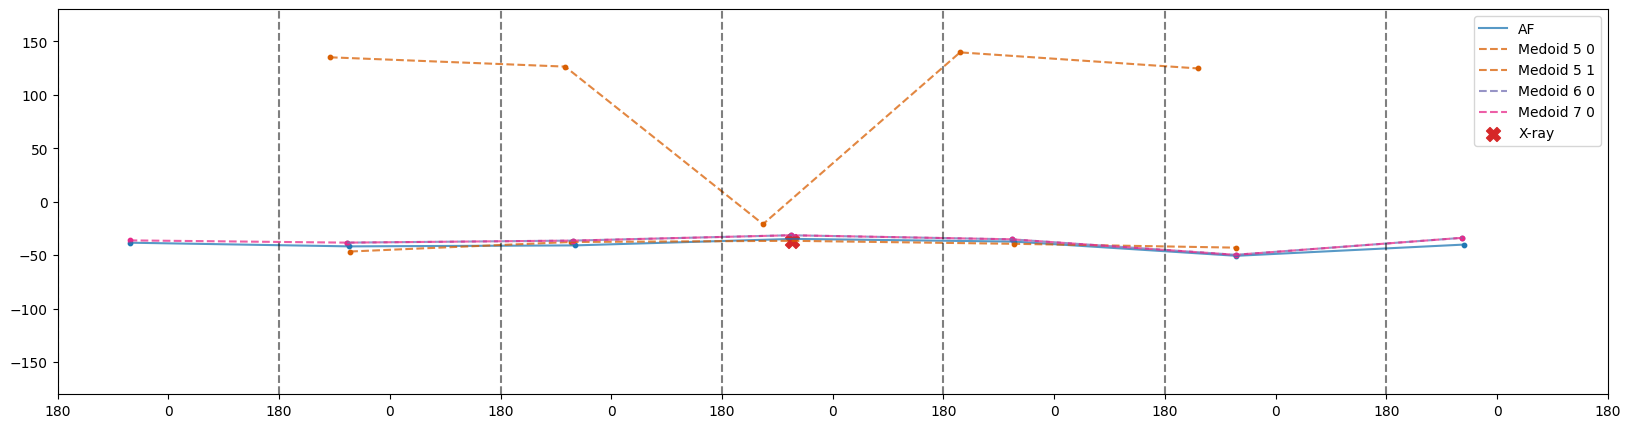

In [115]:
x_medoids, x_af, x_res, y = next(iter(train_dataloader))
plot_ml(4, x_medoids, x_af, y, None, [1,2,3])

In [ ]:
wmax = winsizes[-1]
torch.cat([F.pad(m, (wmax-w, wmax-w)) for m,w in zip(x_medoids[1:], winsizes[1:])], dim=1)

In [127]:
x = x_medoids[0]
mask = x.sum(dim=-1) != 0
xs = [xi[mask[i]] for i,xi in enumerate(x)]
x = torch.nested.nested_tensor(xs)
nn.Linear(8, 128)(x)[511].shape

torch.Size([4, 128])

In [94]:
torch.nested.nested_tensor(x_medoids).to_padded_tensor(padding=0.0).shape

torch.Size([4, 512, 15, 14])

In [148]:
class Net (nn.Module):
    def __init__(self, x_lens, winsizes, device):
        super().__init__()
        self.x_lens = x_lens
        self.winsizes = winsizes
        self.n_medoids = sum(x_lens[1:])
        self.af_input_size = sum([w*2 for w in winsizes])
        self.input_size = sum([l*w*2 for l,w in zip(x_lens, winsizes)])
        self.device = device

        self.d = 128

        self.embs = nn.ModuleList([nn.Linear(w*2, self.d) for w in winsizes[1:]])
        
        self.mha1 = nn.MultiheadAttention(self.d, 8, batch_first=True)
        self.ln1 = nn.LayerNorm((self.n_medoids, self.d))
        self.l1 = nn.Linear(self.d, self.d)

        # self.mha2 = nn.MultiheadAttention(self.d, 8, batch_first=True)
        # self.ln2 = nn.LayerNorm((self.n_medoids, self.d))
        # self.l2 = nn.Linear(self.d, self.d)

        self.out = nn.Sequential(
            nn.Linear(self.d, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        # self.l2 = nn.Linear(32, 16)
        # self.l3 = nn.Linear(16, 2)

    def forward(self, x_medoids, x_af):
        # wmax = self.winsizes[-1]
        # x = torch.cat([F.pad(m, (wmax-w, wmax-w)) for m,w in zip(x_medoids, winsizes)], dim=1)
        # x = torch.cat([F.pad(m, (wmax-w, wmax-w)) for m,w in zip(x_medoids[1:], self.winsizes[1:])], dim=1)
        # x = x.to(device)
        x = torch.cat([self.embs[i](x) for i,x in enumerate(x_medoids[1:])], dim=1)

        # x_af = torch.cat(x_af, dim=1)
        
        x = x + self.mha1(x, x, x)[0]
        x = self.ln1(x)
        x = self.l1(x)
        x = F.relu(x)

        # x = x + self.mha2(x, x, x)[0]
        # x = self.ln2(x)
        # x = self.l2(x)
        # x = F.relu(x)

        # x = x.flatten(1)
        # x = F.relu(self.l1(x))
        # x = F.relu(self.l2(x))
        # x = self.l3(x)

        x = x.max(dim=1)[0]
        x = self.out(x)
        return x
    
class AngleMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x, y):
        def diff(x1, x2):
            d = torch.abs(x1 - x2)
            d = torch.minimum(d, 360-d)
            return d
        return torch.mean(diff(x, y)**2)

model = nn.DataParallel(Net(X_lens, winsizes, device)).to(device)
# model = Net(X_lens, winsizes, device).to(device)
criterion = AngleMSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
sum(p.numel() for p in model.parameters())

98498

In [149]:
x_medoids, x_af, x_res, y = next(iter(train_dataloader))
x_medoids = [m.to(device) for m in x_medoids]
x_af = [af.to(device) for af in x_af]
model(x_medoids, x_af).shape

torch.Size([512, 2])

In [150]:
losses = [[],[]]
for epoch in range(200):
    train_losses = []
    for x_medoids, x_af, x_res, y in train_dataloader:
        x_medoids = [m.to(device) for m in x_medoids]
        x_af = [af.to(device) for af in x_af]        
        y = y.to(device)
        if torch.isnan(y).any():
            continue
        optimizer.zero_grad()
        y_pred = model(x_medoids, x_af)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print('Train:', sum(train_losses) / len(train_dataloader))
    losses[0].append(sum(train_losses) / len(train_dataloader))

    test_losses = []
    for x_medoids, x_af, x_res, y in test_dataloader:
        x_medoids = [m.to(device) for m in x_medoids]
        x_af = [af.to(device) for af in x_af]
        y = y.to(device)
        if torch.isnan(y).any():
            continue
        y_pred = model(x_medoids, x_af)
        loss = criterion(y_pred, y)
        test_losses.append(loss.item())
    print('Test:', sum(test_losses) / len(test_dataloader))
    losses[1].append(sum(test_losses) / len(test_dataloader))

plt.plot(losses[0], label='Train')
# plt.plot(losses[1], label='Test')
plt.legend()
plt.ylim(0, 2000)


Train: 6650.841352583052
Train: 2233.0651668514215
Train: 1385.722880045573
Train: 1160.657690649634
Train: 1033.4404709274704
Train: 965.2544847093187
Train: 922.263141254047
Train: 895.9269376187711
Train: 880.0524605415962
Train: 864.6171330632391
Train: 853.815504469313
Train: 844.3365115603885
Train: 832.4994457347973
Train: 836.4851811039555
Train: 831.3697476773649
Train: 825.786980156426
Train: 817.4072551555462
Train: 807.1428145674972
Train: 803.6772334468258
Train: 800.2215884096987
Train: 788.1157968881968
Train: 786.3102834890555
Train: 777.2013175895622
Train: 771.3675971503731
Train: 767.9587264877182
Train: 764.709406122431
Train: 758.4023624454533
Train: 756.4760219814541
Train: 751.5432783247114
Train: 748.6057981198973
Train: 746.1290626869545
Train: 746.4466954136753
Train: 741.4741227433489
Train: 737.0816743867891
Train: 732.5940914669552
Train: 727.5553220456785
Train: 727.0801410846882
Train: 723.476023631053
Train: 722.9936718640026
Train: 721.565272425746
Trai

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x76329e57b470>>
Traceback (most recent call last):
  File "/home/musa/protein-dihedral-visualization/env/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Train: 687.7038120579075
Train: 685.1840157723642
Train: 685.2553018105997
Train: 687.2672300596495
Train: 688.6824079633833
Train: 685.7479814409136
Train: 681.7858771246832
Train: 679.6212446882918
Train: 678.9514696275866


In [351]:
test_losses = []
for x_medoids, x_af, x_res, y in test_dataloader:
    y = y.to(device)
    if torch.isnan(y).any():
        continue
    y_pred = model(x_medoids, x_af)
    loss = criterion(y_pred, y)
    test_losses.append(loss.item())
print('Test:', sum(test_losses) / len(test_dataloader))

Test: 934.6239562988281


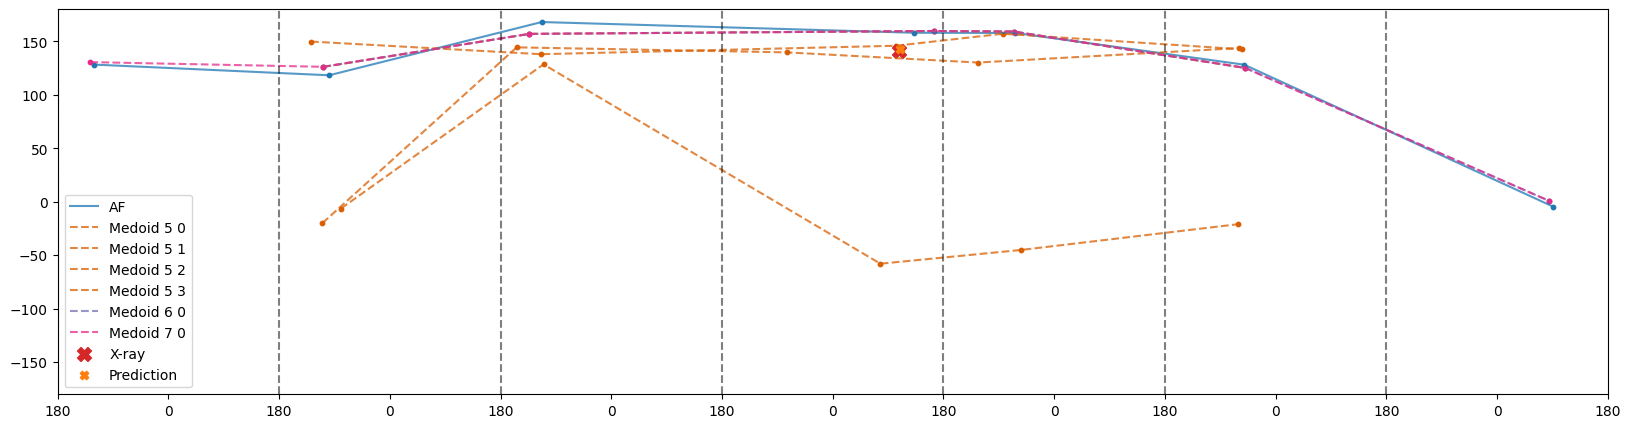

In [259]:
x_medoids, x_af, x_res, y = next(iter(dataloader))
pred = model(x_af).detach()
plot_ml(0, x_medoids, x_af, y, pred)

In [142]:
x_af[0][i, 1]+360, x_af[0][i, winsizes[0]+1]

(tensor(297.3549), tensor(-45.4945))

In [415]:
af_loss = []
for x_medoids, x_af, x_res, y in train_dataloader:
    af = x_af[0][:,[1,5]]
    af_loss.append(criterion(af, y))
print(sum(af_loss) / len(train_dataloader))

af_loss = []
for x_medoids, x_af, x_res, y in test_dataloader:
    af = x_af[0][:,[1,5]]
    af_loss.append(criterion(af, y))
print(sum(af_loss) / len(test_dataloader))

tensor(284.1165)
tensor(262.1390)
